#**ANALISIS PREKURSOR GEMPABUMI DENGAN SATELIT SWARM**

###oleh: Yosi Setiawan

###Pelatihan Pengolahan Model Numerik Geofisika Prekursor Gempabumi Tahun 2025

Pada praktik analisis prekursor gempabumi dengan satelit SWARM ini, software yang digunakan adalah viresclient untuk akuisisi data, dan matplotlib untuk visualisasi yang keduanya berbasis Python. Pengolahan dilakukan di Google Colab untuk memudahkan akses terhadap program dan data yang digunakan tanpa harus menginstall di komputer atau laptop masing-masing peserta. Program ini dibuat berdasarkan jurnal "Swarm-TEC Satellite Measurements as a Potential Earthquake Precursor Together With Other Swarm and CSES Data: The Case of Mw7.6 2019 Papua New Guinea Seismic Event" tulisan Akhoondzadeh et.al (2022) doi: 10.3389/feart.2022.820189.

Akses data satelit SWARM dilakukan dengan memanfaatkan platform VirES (Virtual environments for Earth Scientist). Untuk informasi lebih lanjut dapat dipelajari di:
* https://vires.services/ (Web interface)
* https://viresclient.readthedocs.io (Python interface)
* https://notebooks.vires.services (Guide to Virtual Research Environment / JupyterLab)
* https://earth.esa.int/eogateway/missions/swarm (Swarm mission)

Langkah pertama yang harus dilakukan adalah menginstal CondaColab di Google Colab di akun Google masing-masing. Tekan tombol **Run cell** di sebelah kiri setiap cell atau tekan tombol Ctrl+Enter. Tunggu hingga proses instalasi selesai. Jika muncul notifikasi **Your session crashed for an unknown reason.**, abaikan dan tutup notifikasi tersebut.

In [ ]:
!pip install -q condacolab
import condacolab
condacolab.install()

Selanjutnya, cek apakah instalasi CondaColab telah berhasil. Pastikan hasil yang muncul adalah **Everything looks OK!**.

In [ ]:
import condacolab
condacolab.check()

✨🍰✨ Everything looks OK!


Langkah berikutnya adalah menginstal modul-modul Python yang diperlukan. Proses ini memerlukan waktu yang agak lama. Tunggulah hingga proses selesai.

In [ ]:
!mamba install scipy matplotlib pandas xarray cartopy h5py netCDF4 pytables ipywidgets viresclient


Looking for: ['scipy', 'matplotlib', 'pandas', 'xarray', 'cartopy', 'h5py', 'netcdf4', 'pytables', 'ipywidgets', 'viresclient']

[+] 0.0s
conda-forge/linux-64  ⣾  
conda-forge/noarch    ⣾  [+] 0.1s
conda-forge/linux-64  ⣾  
conda-forge/noarch    ⣾  [+] 0.2s
conda-forge/linux-64  ⣾  
conda-forge/noarch    15%[+] 0.3s
conda-forge/linux-64   2%
conda-forge/noarch    31%[+] 0.4s
conda-forge/linux-64  11%
conda-forge/noarch    49%[+] 0.5s
conda-forge/linux-64  14%
conda-forge/noarch    56%[+] 0.6s
conda-forge/linux-64  17%
conda-forge/noarch    61%[+] 0.7s
conda-forge/linux-64  23%
conda-forge/noarch    75%[+] 0.8s
conda-forge/linux-64  29%
conda-forge/noarch    86%conda-forge/noarch                                
[+] 0.9s
conda-forge/linux-64  35%[+] 1.0s
conda-forge/linux-64  47%[+] 1.1s
conda-forge/linux-64  53%[+] 1.2s
conda-forge/linux-64  63%[+] 1.3s
conda-forge/linux-64  70%[+] 1.4s
conda-forge/linux-64  78%[+] 1.5s
conda-forge/linux-64  87%conda-forge/linux-64                     

###**A. KONFIGURASI**

Untuk mengautentikasi akses ke server VirES, viresclient memerlukan token akses yang menghubungkan komunikasi antara server dan klien ke akun Anda. Ikuti langkah berikut:

1. Buat akun pengguna di https://vires.services
2. Arahkan ke halaman manajemen token VirES, dan buat token baru

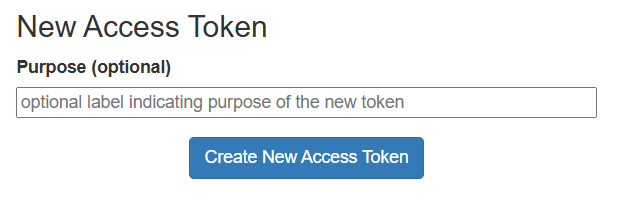

3. Salin token kemudian jalankan perintah berikut dan masukkan kode tokennya.

In [6]:
from viresclient import set_token
set_token("https://vires.services/ows", set_default=True)

Setting access token for https://vires.services/ows... Generate a token at https://vires.services/accounts/tokens/

Token saved for https://vires.services/ows


Selanjutnya import modul-modul Python yang akan digunakan

In [1]:
from viresclient import SwarmRequest
import datetime as dt
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from geopy.distance import distance
import numpy as np
import pandas as pd
import xarray as xr
import os, glob
#from google.colab import drive
#drive.mount('/content/gdrive')

###**B. Memilih Gempa Target**

Sebelum mengakses data SWARM, kita tentukan dahulu gempa target yang akan dianalisis prekursornya. Informasi yang diperlukan adalah:
1. Lokasi episenter (lintang, bujur)
2. Waktu gempa (UTC)
3. Magnitudo dan kedalaman

In [2]:
lon = 120.62
lat = -1.30
OT = dt.datetime(2025, 8, 16, 22, 38, 52) # Tahun, Bulan, Tanggal, Jam, Menit, Detik
mag = 6.0
depth = 10

Magnitudo gempa berkaitan dengan area Dobrovolsky, yaitu wilayah di sekitar episenter gempa bumi yang diperkirakan dapat menunjukkan anomali fisik atau geofisika sebelum terjadinya gempa. Istilah ini digunakan berdasarkan paper Dobrovolsky et.al (1979) dengan judul "Estimation of the size of earthquake preparation zones". Luas area Dobrovolsky didefinisikan berdasarkan rumus empiris:


<p align=center>$𝑅 = 10^{0.43 \times M}$</p>

di mana:

$R$ adalah radius terpengaruh (dalam kilometer)

$M$ adalah magnitudo gempa

Misalnya untuk gempa bermagnitudo 6.5:

<p align=center>$𝑅 = 10^{0.43 \times 6.5} \approx 10^{2.795} \approx 626 km$</p>


Maka, anomali geofisika yang muncul dalam radius 600–650 km dari episenter dianggap masih mungkin berkaitan dengan gempa tersebut.

Dalam studi prekursor (termasuk analisis dengan data satelit SWARM), area Dobrovolsky digunakan untuk:

* Membatasi wilayah studi (spatial window)

* Menghindari bias dengan melihat anomali terlalu jauh dari pusat aktivitas

* Mengidentifikasi anomali lokal yang mungkin valid sebagai prekursor

Namun, area Dobrovolsky adalah pendekatan empiris, bukan pendekatan fisis dan area Dobrovolsky lebih cocok untuk gempa tektonik besar (≥ M5.5). Dalam radius ini tidak berarti anomali pasti muncul di dalamnya, tetapi hanya menjadi batas kewajaran untuk dianalisis.

Kita plot lokasi gempa:

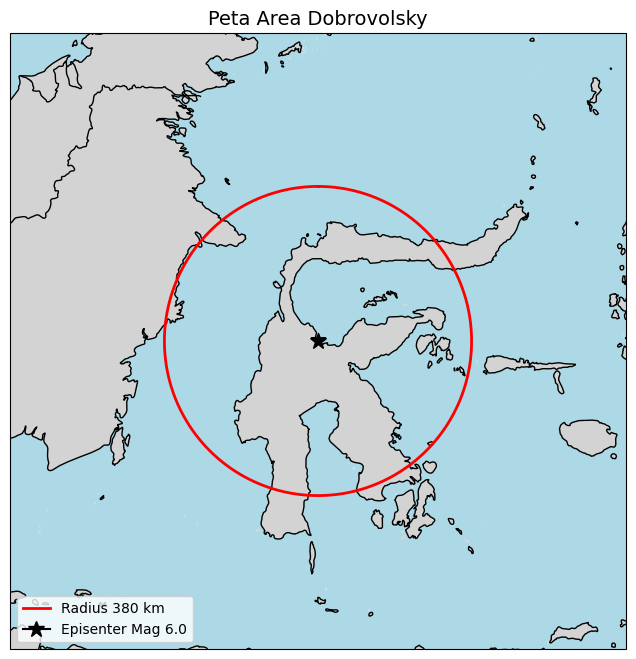

In [3]:
dobrovolsky = 10**(0.43*mag)

# Fungsi untuk membuat koordinat lingkaran
def create_circle(lat, lon, radius_km, num_points=360):
    angles = np.linspace(0, 360, num_points)
    lats, lons = [], []
    for angle in angles:
        point = distance(kilometers=radius_km).destination((lat, lon), bearing=angle)
        lats.append(point.latitude)
        lons.append(point.longitude)
    return lats, lons

# Buat peta
fig = plt.figure(figsize=(8, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([lon-dobrovolsky/111*2, lon+dobrovolsky/111*2, lat-dobrovolsky/111*2, lat+dobrovolsky/111*2], crs=ccrs.PlateCarree())

# Tambahkan fitur
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')

# Tambahkan lingkaran
circle_lat, circle_lon = create_circle(lat, lon, dobrovolsky)
ax.plot(circle_lon, circle_lat, transform=ccrs.PlateCarree(), color='red', linewidth=2, label=f'Radius {dobrovolsky:.0f} km')

# Tambahkan titik episenter
ax.plot(lon, lat, marker='*', color='black', transform=ccrs.PlateCarree(), markersize=12, label=f'Episenter Mag {mag:.1f}')

# Tambahkan legenda dan judul
plt.legend(loc='lower left')
plt.title('Peta Area Dobrovolsky', fontsize=14)
plt.show()

###**C. Definisikan Window Analisis**

Dari penelitian-penelitian sebelumnya, anomali magnetik maupun TEC bisa muncul hingga sekitar 1 bulan sebelum terjadi gempa. Pada pengolahan data ini, kita batasi data 2 minggu sebelum kejadian gempa sebagai periode evaluasi awal anomali hingga maksimum 1 hari setelah terjadi gempa.

In [4]:
start_time = OT - dt.timedelta(days=14)
end_time = OT + dt.timedelta(days=1)

Selanjutnya, kita akan batasi data dari satelit SWARM dalam rentang waktu window analisis dan juga berdasarkan luas area Dobrovolsky (data dibatasi hanya saat satelit SWARM melintas di dalam area Dobrovolsky).

Untuk pengolahan ini kita akan menggunakan data TEC dan data magnet dengan resolusi 1 detik dari ketiga satelit SWARM (alpha, bravo, charlie).

**Download data Magnet**

In [8]:
days = (end_time - start_time).days
print('Downloading ', str(days), ' days of MAG data from ', start_time.strftime('%Y-%m-%d'), ' to ', end_time.strftime('%Y-%m-%d'))

sats = [("A", "SW_OPER_MAGA_LR_1B"), ("B", "SW_OPER_MAGB_LR_1B"), ("C", "SW_OPER_MAGC_LR_1B")]

for sat, coll in sats:
    for i in range(days):
        t0 = start_time + dt.timedelta(days=i)
        t1 = t0 + dt.timedelta(days=1)

        filename = f"MAG_{sat}_{t0.strftime('%Y-%m-%d')}.nc"
        # Skip jika file sudah ada
        if not os.path.exists(filename):
            request = SwarmRequest()
            request.set_collection(coll)
            request.set_products(
                measurements=["B_NEC"],
                auxiliaries=["Kp", "Dst", "F107"],
                models=["IGRF"])

            # Download data setiap interval waktu
            try:
                data = request.get_between(t0, t1, show_progress=False)
                df = data.as_dataframe(expand=True)
                ds = df.to_xarray()
            except RuntimeError:
                print(f"No data for {filename} - data not downloaded")

            try:
                ds.to_netcdf(filename)
                print(f"saved {filename}")
            except AttributeError:
                print(f"No data for {filename} - file not created")

        else:
            print(f"File {filename} is exist")
            continue

saved MAG_A_2025-08-02.nc
saved MAG_A_2025-08-03.nc
saved MAG_A_2025-08-04.nc
saved MAG_A_2025-08-05.nc
saved MAG_A_2025-08-06.nc
saved MAG_A_2025-08-07.nc
saved MAG_A_2025-08-08.nc
saved MAG_A_2025-08-09.nc
saved MAG_A_2025-08-10.nc
saved MAG_A_2025-08-11.nc
saved MAG_A_2025-08-12.nc
saved MAG_A_2025-08-13.nc
saved MAG_A_2025-08-14.nc
saved MAG_A_2025-08-15.nc
saved MAG_A_2025-08-16.nc
saved MAG_B_2025-08-02.nc
saved MAG_B_2025-08-03.nc
saved MAG_B_2025-08-04.nc
saved MAG_B_2025-08-05.nc
saved MAG_B_2025-08-06.nc
saved MAG_B_2025-08-07.nc
saved MAG_B_2025-08-08.nc
saved MAG_B_2025-08-09.nc
saved MAG_B_2025-08-10.nc
saved MAG_B_2025-08-11.nc
saved MAG_B_2025-08-12.nc
saved MAG_B_2025-08-13.nc
saved MAG_B_2025-08-14.nc
saved MAG_B_2025-08-15.nc
saved MAG_B_2025-08-16.nc
saved MAG_C_2025-08-02.nc
saved MAG_C_2025-08-03.nc
saved MAG_C_2025-08-04.nc
saved MAG_C_2025-08-05.nc
saved MAG_C_2025-08-06.nc
saved MAG_C_2025-08-07.nc
saved MAG_C_2025-08-08.nc
saved MAG_C_2025-08-09.nc
saved MAG_C_

**Download data TEC**

In [9]:
days = (end_time - start_time).days
print('Downloading ', str(days), ' days of TEC data from ', start_time.strftime('%Y-%m-%d'), ' to ', end_time.strftime('%Y-%m-%d'))

sats = [("A", "SW_OPER_TECATMS_2F"), ("B", "SW_OPER_TECBTMS_2F"), ("C", "SW_OPER_TECCTMS_2F")]

for sat, coll in sats:
    for i in range(days):
        t0 = start_time + dt.timedelta(days=i)
        t1 = t0 + dt.timedelta(days=1)

        filename = f"TEC_{sat}_{t0.strftime('%Y-%m-%d')}.nc"
        # Skip jika file sudah ada
        if not os.path.exists(filename):
            request = SwarmRequest()
            request.set_collection(coll)
            request.set_products(
                measurements=["Absolute_VTEC"],
                auxiliaries=["Kp", "Dst", "F107"])

            # Download data setiap interval waktu
            try:
                data = request.get_between(t0, t1, show_progress=False)
                df = data.as_dataframe(expand=True)
                ds = df.to_xarray()
            except RuntimeError:
                print(f"No data for {filename} - data not downloaded")

            try:
                ds.to_netcdf(filename)
                print(f"saved {filename}")
            except AttributeError:
                print(f"No data for {filename} - file not created")

        else:
            print(f"File {filename} is exist")
            continue

saved TEC_A_2025-08-02.nc
saved TEC_A_2025-08-03.nc
saved TEC_A_2025-08-04.nc
saved TEC_A_2025-08-05.nc
saved TEC_A_2025-08-06.nc
saved TEC_A_2025-08-07.nc
saved TEC_A_2025-08-08.nc
saved TEC_A_2025-08-09.nc
saved TEC_A_2025-08-10.nc
saved TEC_A_2025-08-11.nc
saved TEC_A_2025-08-12.nc
saved TEC_A_2025-08-13.nc
saved TEC_A_2025-08-14.nc
saved TEC_A_2025-08-15.nc
saved TEC_A_2025-08-16.nc
saved TEC_B_2025-08-02.nc
saved TEC_B_2025-08-03.nc
saved TEC_B_2025-08-04.nc
saved TEC_B_2025-08-05.nc
saved TEC_B_2025-08-06.nc
saved TEC_B_2025-08-07.nc
saved TEC_B_2025-08-08.nc
saved TEC_B_2025-08-09.nc
saved TEC_B_2025-08-10.nc
saved TEC_B_2025-08-11.nc
saved TEC_B_2025-08-12.nc
saved TEC_B_2025-08-13.nc
saved TEC_B_2025-08-14.nc
saved TEC_B_2025-08-15.nc
saved TEC_B_2025-08-16.nc
saved TEC_C_2025-08-02.nc
saved TEC_C_2025-08-03.nc
saved TEC_C_2025-08-04.nc
saved TEC_C_2025-08-05.nc
saved TEC_C_2025-08-06.nc
saved TEC_C_2025-08-07.nc
saved TEC_C_2025-08-08.nc
saved TEC_C_2025-08-09.nc
saved TEC_C_

Selanjutnya, kita baca data yang telah didownload. Karena keterbatasan kemampuan komputasi, data kita baca berdasarkan jenis data (magnetik atau TEC) dan nama satelitnya (A, B, atau C).

In [5]:
# Fungsi: filter file berdasarkan rentang tanggal
def filter_files_by_date(prefix, start_date, end_date, date_fmt="%Y-%m-%d"):
    # Ambil semua file sesuai prefix
    all_files = glob.glob(f"{prefix}*.nc")

    # Siapkan rentang waktu
    start_dt = start_date
    end_dt = end_date

    filtered_files = []
    for file in all_files:
        # Ambil tanggal dari nama file (harus di akhir sebelum .nc)
        date_str = file.split("_")[-1].replace(".nc", "")
        try:
            file_dt = dt.datetime.strptime(date_str, date_fmt)
            if start_dt <= file_dt <= end_dt:
                filtered_files.append(file)
        except ValueError:
            continue  # lewati jika format tidak cocok
    return filtered_files

# Fungsi: membaca file dan abaikan jika kosong
def read_nc(filenames):
    empty_files = []
    for filename in filenames:
        try:
            _ds = xr.open_dataset(filename)
            if _ds["Timestamp"].size == 0:
                empty_files.append(filename)
        except Exception:
            empty_files.append(filename)  # abaikan file yang error
    filenames = [f for f in filenames if f not in empty_files]
    if len(filenames) == 0:
        return None
    
    datasets = []
    for filename in filenames:
        ds = xr.open_mfdataset(filename)
        datasets.append(ds)
    combined_ds = xr.concat(datasets, dim='Timestamp')

    return combined_ds

ds_MAG_A = read_nc(filter_files_by_date("MAG_A_", start_time, end_time))
# ds_MAG_B = read_nc(filter_files_by_date("MAG_B_", start_time, end_time))
# ds_MAG_C = read_nc(filter_files_by_date("MAG_C_", start_time, end_time))
#ds_TEC_A = read_nc(filter_files_by_date("TEC_A_", start_time, end_time))
# ds_TEC_B = read_nc(filter_files_by_date("TEC_B_", start_time, end_time))
# ds_TEC_C = read_nc(filter_files_by_date("TEC_C_", start_time, end_time))


Data magnetik dari satelit SWARM masih mengandung komponen medan magnet utama Bumi yang berasal dari internal Bumi. Pada pengolahan prekursor gempa dengan data magnetik Swarm, kita harus mengurangkan nilai IGRF (International Geomagnetic Reference Field) terlebih dahulu karena kita ingin memisahkan medan utama Bumi dari sinyal kecil yang menjadi kandidat anomali.

Nilai IGRF ini perlu dikurangkan karena:
1. Mengisolasi anomali kecil

    Prekursor seismik biasanya hanya berupa gangguan sangat kecil (puluhan nT atau bahkan lebih kecil) dibandingkan dengan total medan utama yang bisa mencapai ~50.000 nT. Jika tidak dikurangi, sinyal anomali akan tenggelam dalam dominasi medan utama.

2. Membedakan variasi global dan lokal

    Medan utama Bumi (IGRF) memiliki pola global yang relatif stabil.
    Prekursor gempa bersifat lokal/regional dan muncul sebagai deviasi dari normal.
    Dengan mengurangi IGRF, kita hanya menyisakan residual yang berisi kombinasi variasi eksternal (aktivitas matahari/geomagnetik) dan variasi lokal (misalnya potensi prekursor seismik).

3. Konsistensi antar lokasi & waktu

    Karena satelit Swarm terus bergerak di lintasan berbeda, tanpa koreksi IGRF sulit membandingkan data antar lintasan/hari. Residual setelah dikurangi IGRF jauh lebih konsisten untuk dianalisis secara statistik.

In [6]:
def residual(ds):
    try:
        ds['B_NEC_res_E'] = ds['B_NEC_E'] - ds['B_NEC_IGRF_E']
        ds['B_NEC_res_N'] = ds['B_NEC_N'] - ds['B_NEC_IGRF_N']
        ds['B_NEC_res_C'] = ds['B_NEC_C'] - ds['B_NEC_IGRF_C']
    except:
        ds = ds
    return ds

ds_residual_MAG_A = residual(ds_MAG_A)
#ds_residual_TEC_A = residual(ds_TEC_A)

Berdasarkan publikasi dari Akhoondzadeh et.al. (2022) yang menjadi acuan dari pembuatan program ini, data magnetik dan TEC nantinya akan difilter jika terjadi gangguan magnetik berdasarkan nilai indeks Dst, F10.7 dan ap. Data yang telah didownload tidak memiliki informasi indeks ap tetapi memiliki informasi indeks Kp, sehingga data Kp ini kita konversikan dahulu ke indeks ap.

Kp, atau planetary K-index, adalah indeks global yang dihitung setiap 3 jam berdasarkan data dari sejumlah stasiun magnet di lintang menengah. Nilai Kp berskala 0 hingga 9, dengan subdivisi seperti 2-, 2o, atau 2+, dan bersifat logaritmik. Artinya, kenaikan satu unit Kp dapat menunjukkan peningkatan energi geomagnetik yang cukup besar. Karena sifatnya diskret dan berbasis kategori, Kp biasanya digunakan untuk mengklasifikasikan kondisi geomagnetik, misalnya menentukan apakah Bumi sedang berada pada kondisi tenang, aktif, atau badai geomagnetik.

Sementara itu, indeks ap adalah bentuk linear yang diturunkan langsung dari Kp. Setiap nilai Kp dikonversi ke nilai ap yang setara, misalnya Kp 0o setara dengan ap 0, Kp 3o setara dengan ap 15, hingga Kp 9o setara dengan ap 400. Berbeda dengan Kp yang logaritmik, ap bersifat linier dengan satuan “nT”, sehingga lebih cocok untuk keperluan analisis numerik, perhitungan statistik, atau model empiris.

In [7]:
def convert_kp_to_ap(kp):
    # lookup table
    kp_vals = np.array([
        0.000, 0.333, 0.667, 1.000, 1.333, 1.667, 2.000, 2.333, 2.667,
        3.000, 3.333, 3.667, 4.000, 4.333, 4.667, 5.000, 5.333, 5.667,
        6.000, 6.333, 6.667, 7.000, 7.333, 7.667, 8.000, 8.333, 8.667, 9.000
    ])
    ap_vals = np.array([
          0,   2,   3,   4,   5,   6,   7,   9,  12,
         15,  18,  22,  27,  32,  39,  48,  56,  67,
         80,  94, 111, 132, 154, 179, 208, 236, 300, 400
    ])
    return np.interp(kp, kp_vals, ap_vals)

def ap(ds):
    ds["ap"] = xr.apply_ufunc(
        convert_kp_to_ap,
        ds["Kp"],
        vectorize=True,
        dask="parallelized" if ds["Kp"].chunks else False,
        output_dtypes=[float]
    )
    return ds

ds_ap_MAG_A = ap(ds_residual_MAG_A)
#ds_ap_TEC_A = ap(ds_residual_TEC_A)

Selanjutnya kita plot data yang telah didownload beserta indeks-indeks geomagnetiknya. Proses plotting data mungkin membutuhkan waktu yang lama, tergantung dengan ukuran data yang didownload.

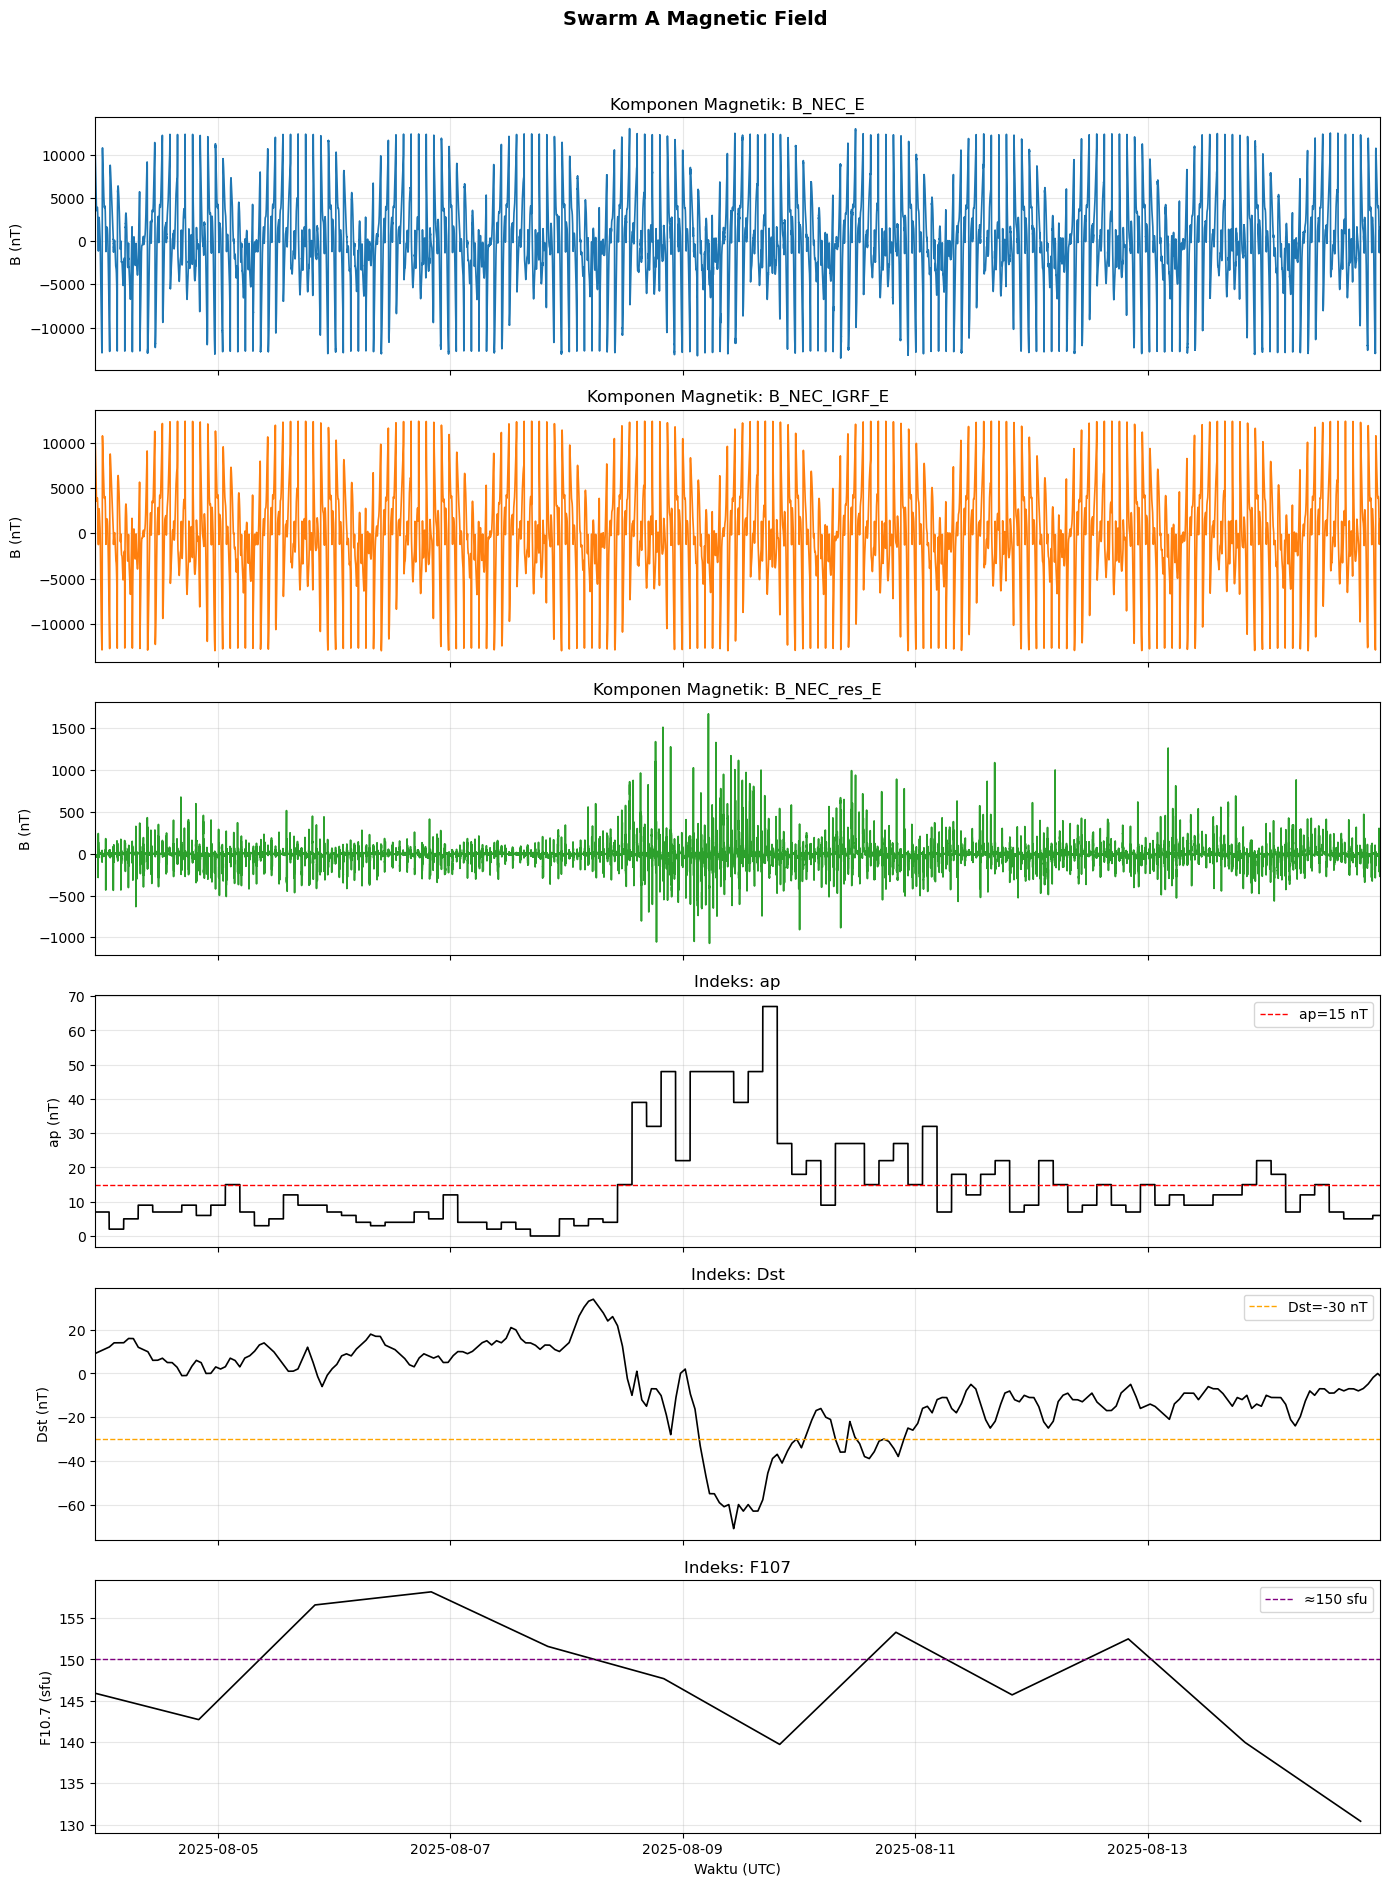

In [8]:
def _get_time_coord(ds):
    if 'Timestamp' in ds.coords: return 'Timestamp'
    if 'time' in ds.coords: return 'time'
    raise KeyError("Tidak ditemukan koordinat waktu 'Timestamp' atau 'time'.")

def _to_np(da):
    return da.compute().values if hasattr(da.data, "compute") else da.values

def plot_swarm(
    ds,
    components=('Absolute_VTEC', 'B_NEC_N', 'B_NEC_IGRF_N', 'B_NEC_res_N', 'B_NEC_E', 'B_NEC_IGRF_E', 'B_NEC_res_E', 'B_NEC_C', 'B_NEC_IGRF_C', 'B_NEC_res_C'),
    index_vars=('Kp', 'ap', 'Dst', 'F107'),   # dibuatkan subplot jika tersedia
    time_slice=None,
    title="Swarm Data"
):
    tname = _get_time_coord(ds)
    dss = ds.sel({tname: slice(*time_slice)}) if time_slice else ds
    time_vals = _to_np(dss[tname])

    # siapkan daftar panel: satu subplot per komponen
    present_components = [v for v in components if v in dss]

    if not present_components:
        raise ValueError("Tidak ada variabel komponen magnetik/TEC yang ditemukan di dataset.")

    panels = [('comp', var) for var in present_components]

    # indeks opsional
    for iv in (index_vars or ()):
        if iv in dss:
            panels.append(('index', iv))

    nrows = len(panels)
    fig, axes = plt.subplots(nrows, 1, figsize=(14, 3.2*nrows), sharex=True)
    if nrows == 1:
        axes = [axes]

    # warna berbeda per komponen
    comp_color_map = {
        'Absolute_VTEC': 'tab:blue',
        'B_NEC_N': 'tab:blue',
        'B_NEC_IGRF_N': 'tab:orange',
        'B_NEC_res_N': 'tab:green',
        'B_NEC_E': 'tab:blue',
        'B_NEC_IGRF_E': 'tab:orange',
        'B_NEC_res_E': 'tab:green',
        'B_NEC_C': 'tab:blue',
        'B_NEC_IGRF_C': 'tab:orange',
        'B_NEC_res_C': 'tab:green'
    }
    default_colors = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:brown']

    for i, (ax, (kind, var)) in enumerate(zip(axes, panels)):
        if kind == 'comp':
            y = _to_np(dss[var])
            color = comp_color_map.get(var, default_colors[i % len(default_colors)])
            ax.plot(time_vals, y, lw=1.2, color=color)
            if 'B_NEC' in var:
                ax.set_title(f"Komponen Magnetik: {var}")
                ax.set_ylabel("B (nT)")
            elif 'Absolute_VTEC' in var:
                ax.set_title("Total Electron Content (TEC)")
                ax.set_ylabel("VTEC (TECU)")
            else:
                ax.set_title(f"Komponen: {var}")
            ax.grid(True, alpha=0.3)

        else:  # index
            y = _to_np(dss[var])
            ax.plot(time_vals, y, lw=1.2, color='black')
            ax.set_title(f"Indeks: {var}")
            if var == 'Kp':
                ax.set_ylabel('Kp')
            elif var == 'ap':
                ax.set_ylabel('ap (nT)')
            elif var == 'Dst':
                ax.set_ylabel('Dst (nT)')
            elif var in ('F10', 'F107', 'F10.7'):
                ax.set_ylabel('F10.7 (sfu)')
            ax.grid(True, alpha=0.3)
            lname = var.lower()
            if lname == 'kp':
                ax.axhline(3, ls='--', lw=1, label='Kp=3', color='red'); ax.legend()
            elif lname == 'ap':
                ax.axhline(15, ls='--', lw=1, label='ap=15 nT', color='red'); ax.legend()
            elif lname == 'dst':
                ax.axhline(-30, ls='--', lw=1, label='Dst=-30 nT', color='orange'); ax.legend()
            elif lname in ('f10', 'f107', 'f10.7'):
                ax.axhline(150, ls='--', lw=1, label='≈150 sfu', color='purple'); ax.legend()

    # rapikan sumbu-X agar pas dengan data
    for ax in axes:
        ax.set_xlim(time_vals.min(), time_vals.max())
    axes[-1].set_xlabel("Waktu (UTC)")

    fig.suptitle(title, fontsize=14, fontweight='bold')
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

plot_swarm(ds_ap_MAG_A, components=('B_NEC_E', 'B_NEC_IGRF_E', 'B_NEC_res_E'), index_vars=('ap', 'Dst', 'F107'), time_slice=(start_time.strftime('%Y-%m-%d'), end_time.strftime('%Y-%m-%d')), title="Swarm A Magnetic Field")
#plot_swarm(ds_ap_TEC_A, components=(['Absolute_VTEC']), index_vars=('ap', 'Dst', 'F107'), time_slice=(start_time.strftime('%Y-%m-%d'), end_time.strftime('%Y-%m-%d')), title="Swarm A TEC")


Data yang telah didownload merupakan data global. Data ini perlu kita potong sesuai dengan area of interest kita, yaitu berdasarkan area Dobrovolsky sesuai dengan lokasi gempa yang akan diidentifikasi prekursornya. Namun, untuk menyeragamkan panjang lintasan maka area of interest dibuat menjadi kotak dengan titik tengah episenter dan panjang kotak adalah dua kali radius area Dobrovolsky.

In [26]:
# Fungsi haversine untuk hitung jarak antar koordinat (dalam km)
def haversine(lat1, lon1, lat2, lon2):
    R = 6371.0  # Radius bumi dalam km
    phi1 = np.radians(lat1)
    phi2 = np.radians(lat2)
    dphi = np.radians(lat2 - lat1)
    dlambda = np.radians(lon2 - lon1)

    a = np.sin(dphi / 2.0)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(dlambda / 2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c

def filter_area_circle(ds, lat, lon, dobrovolsky):
    # Hitung jarak untuk semua titik
    distance = haversine(lat, lon, ds['Latitude'], ds['Longitude'])

    # Hitung mask boolean (jarak <= radius) lalu evaluasi
    mask = (distance <= dobrovolsky).compute()

    # Terapkan ke dataset
    ds_filtered = ds.where(mask, drop=True)
    return ds_filtered

def filter_area(ds, lat, lon, dobrovolsky):
    # konversi km -> derajat
    dlat = dobrovolsky / 111.0
    dlon = dobrovolsky / (111.0 * np.cos(np.radians(lat)))
    
    # tentukan batas kotak
    lat_min, lat_max = lat - dlat, lat + dlat
    lon_min, lon_max = lon - dlon, lon + dlon
    
    # filter dengan .where
    mask = ((ds['Latitude'] >= lat_min) & (ds['Latitude'] <= lat_max) &
            (ds['Longitude'] >= lon_min) & (ds['Longitude'] <= lon_max)).compute()
    ds_filtered = ds.where(mask, drop=True)
    return ds_filtered

ds_area_MAG_A = filter_area(ds_ap_MAG_A, lat, lon, dobrovolsky)
#ds_area_TEC_A = filter_area(ds_TEC_A, lat, lon, dobrovolsky)

Kita plot jalur terbang satelit Swarm didalam area Dobrovolsky. Sebagai informasi, satelit Swarm terdiri dari tiga satelit identik: Swarm-A, Swarm-B, dan Swarm-C. Swarm A & C terbang berpasangan dalam orbit yang hampir identik, dekat satu sama lain (formasi side-by-side). Ketinggiannya sekitar 450 km dari permukaan Bumi. Konfigurasi ini memungkinkan untuk membandingkan variasi spasial medan magnet dalam skala kecil (lintang dan bujur). Sedangkan Swarm B terbang lebih tinggi, sekitar 510 km, dalam bidang orbit yang berbeda dari A & C. Oleh karena itu, saat tiap satelit diplot akan menghasilkan jalur yang berbeda. Periode orbit satelit Swarm sekitar 95 menit per revolusi, sehingga ketiga satelit mengelilingi Bumi sekitar 15 kali per hari.

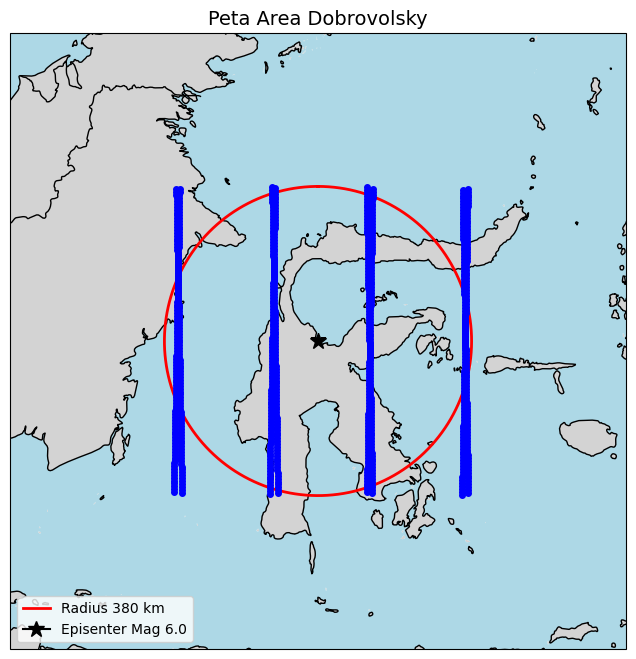

In [27]:
def plot_area(ds_plot, lat, lon, dobrovolsky, mag):
    # Buat peta
    fig = plt.figure(figsize=(8, 8))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent([lon-dobrovolsky/111*2, lon+dobrovolsky/111*2, lat-dobrovolsky/111*2, lat+dobrovolsky/111*2], crs=ccrs.PlateCarree())

    # Tambahkan fitur
    ax.add_feature(cfeature.BORDERS)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.LAND, facecolor='lightgray')
    ax.add_feature(cfeature.OCEAN, facecolor='lightblue')

    # Tambahkan lingkaran
    circle_lat, circle_lon = create_circle(lat, lon, dobrovolsky)
    ax.plot(circle_lon, circle_lat, transform=ccrs.PlateCarree(), color='red', linewidth=2, label=f'Radius {dobrovolsky:.0f} km')

    # Tambahkan titik episenter
    ax.plot(lon, lat, marker='*', color='black', transform=ccrs.PlateCarree(), markersize=12, label=f'Episenter Mag {mag:.1f}')

    # Tambahkan titik data
    ax.plot(ds_plot['Longitude'], ds_plot['Latitude'], marker='.', linestyle='None', color='blue', transform=ccrs.PlateCarree(), markersize=8)

    # Tambahkan legenda dan judul
    plt.legend(loc='lower left')
    plt.title('Peta Area Dobrovolsky', fontsize=14)
    plt.show()


plot_area(ds_area_MAG_A, lat, lon, dobrovolsky, mag)
#plot_area(ds_area_TEC_A, lat, lon, dobrovolsky, mag)

Dalam pengolahan prekursor menggunakan data satelit Swarm, data harus dipisahkan antara data pada siang dan malam hari. Hal ini karena data pada kedua waktu tersebut memiliki karakteristik yang berbeda. Pada siang hari, radiasi ultraviolet (UV) dan sinar-X dari Matahari sangat kuat, sehingga menyebabkan ionisasi maksimum di ionosfer. Akibatnya, Total Electron Content (TEC) lebih tinggi, lapisan ionosfer lebih padat, dan variasi geomagnetik eksternal lebih kuat. Sinyal prekursor seismik bisa lebih sulit diamati karena tertutup oleh variasi alami harian yang besar.

Sedangkan pada malam hari, karena tidak ada ionisasi langsung dari Matahari, densitas elektron turun signifikan. Kondisi ionosfer relatif lebih tenang, sehingga anomali kecil (misalnya fluktuasi TEC atau residual magnetik yang terkait aktivitas seismik) lebih mudah terdeteksi dibanding siang hari.

In [15]:
def day_night(ds):
    # 1. Hitung offset waktu lokal (dari longitude)
    local_offset_hours = ds['Longitude'] / 15.0
    local_offset_ns = (local_offset_hours * 3600 * 1e9).astype('timedelta64[ns]')

    # 2. Hitung waktu lokal
    time_local = ds['Timestamp'] + local_offset_ns
    hour_local = time_local.dt.hour.compute()

    # 3. Buat mask siang (06:00–18:00)
    day_mask = (hour_local >= 6) & (hour_local < 18)
    night_mask = ~day_mask

    # 4. Pisahkan data siang dan malam
    ds_day = ds.where(day_mask, drop=True).compute()
    ds_night = ds.where(night_mask, drop=True).compute()
    return ds_day, ds_night

ds_day_MAG_A, ds_night_MAG_A = day_night(ds_area_MAG_A)
#ds_day_TEC_A, ds_night_TEC_A = day_night(ds_area_TEC_A)

Kita plot kembali lintasan satelit Swarm yang telah dipisahkan berdasarkan waktu siang dan malam.

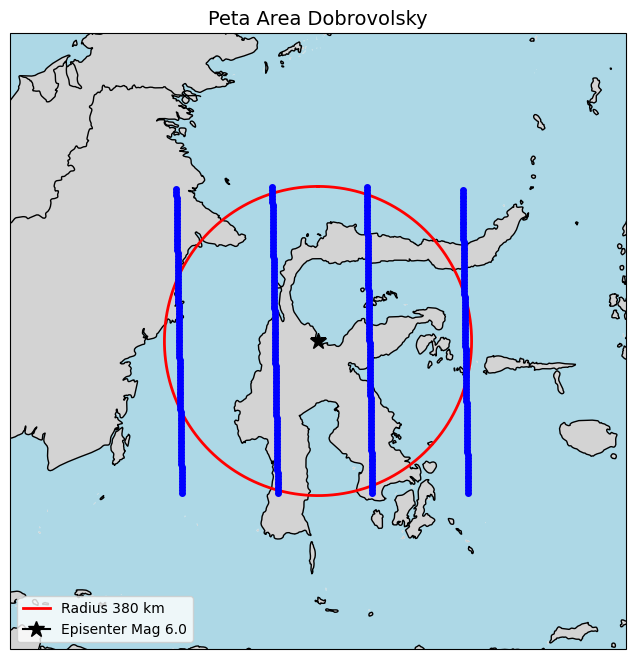

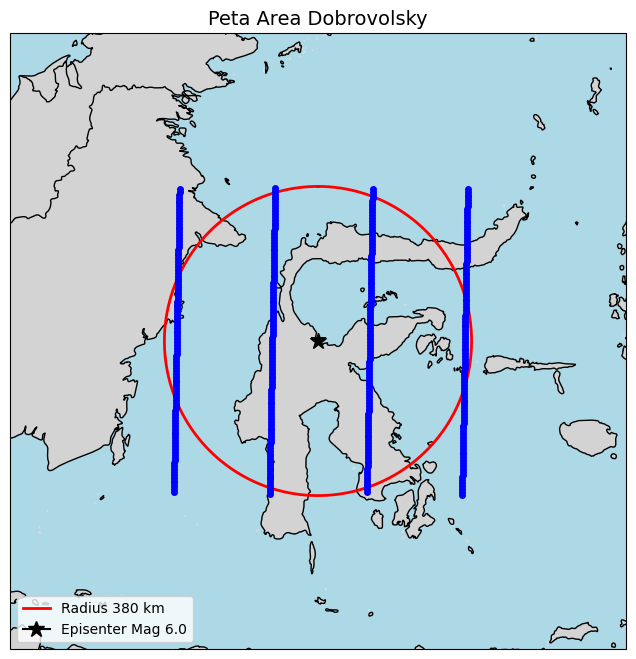

In [16]:
plot_area(ds_day_MAG_A, lat, lon, dobrovolsky, mag)
plot_area(ds_night_MAG_A, lat, lon, dobrovolsky, mag)

#plot_area(ds_day_TEC_A, lat, lon, dobrovolsky, mag)
#plot_area(ds_night_TEC_A, lat, lon, dobrovolsky, mag)

Data yang telah dipisahkan berdasarkan waktu siang dan malam dihitung nilai mediannya per hari. Nilai median digunakan karena median lebih tahan terhadap adanya outlier. Data satelit Swarm sering dipengaruhi gangguan jangka pendek, misalnya badai geomagnetik, gangguan instrumen, atau noise ionosfer. Nilai ata-rata (mean) bisa sangat terdistorsi oleh nilai ekstrem, sedangkan median tetap merepresentasikan "nilai tipikal" dari distribusi harian. Selain itu, variasi geomagnetik dan TEC biasanya asimetris. Dalam kondisi seperti ini, median lebih stabil dibandingkan mean, karena median selalu mengambil titik tengah data.

**Menurut Akhoondzadeh et.al (2022), komponen Y (atau E dalam referensi satelit) lebih sensitif terhadap arus ionosfer yang bisa berubah akibat peningkatan konduktivitas sebelum gempa.** Sehingga, untuk pengolahan data magnetik, komponen yang digunakan adalah komponen E.

In [17]:
def median_day_night(ds, code):
    # 1. Hitung median harian untuk data siang dan malam
    # 2. Gunakan 'B_res_E' jika ada, jika tidak gunakan 'Absolute_VTEC'    
    if code == 'MAG':
        ds_median = ds['B_NEC_res_E'].groupby('Timestamp.date').median(dim='Timestamp')
    elif code == 'TEC':
        ds_median = ds['Absolute_VTEC'].groupby('Timestamp.date').median(dim='Timestamp')
    return ds_median

day_median_MAG_A, night_median_MAG_A = median_day_night(ds_day_MAG_A, 'MAG'), median_day_night(ds_night_MAG_A, 'MAG')
#day_median_TEC_A, night_median_TEC_A = median_day_night(ds_day_TEC_A, 'TEC'), median_day_night(ds_night_TEC_A, 'TEC')


Satu hari data akan menghasilkan satu nilai median. Selanjutnya kita plot data median ini.

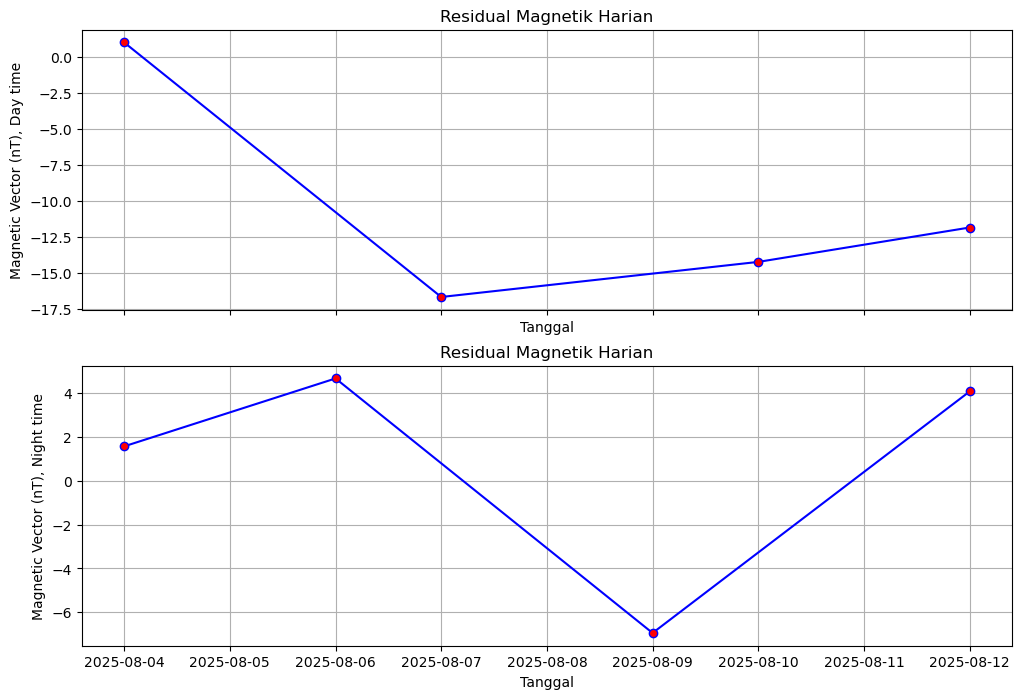

In [18]:
def plot_median(ds_day, ds_night):
    fig, ax = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
    ax[0].plot(ds_day['date'], ds_day, 'o-', markerfacecolor='red', color='blue')
    ax[0].set_xlabel("Tanggal")
    if 'B_NEC' in ds_day.name:
        ax[0].set_title("Residual Magnetik Harian")
        ax[0].set_ylabel("Magnetic Vector (nT), Day time")
    elif 'Absolute_VTEC' in ds_day.name:
        ax[0].set_title("Residual Harian Total Electron Content (TEC)")
        ax[0].set_ylabel("Vertical TEC (TECU), Day time")
    ax[0].grid(True)

    ax[1].plot(ds_night['date'], ds_night, 'o-', markerfacecolor='red', color='blue')
    ax[1].set_xlabel("Tanggal")
    if 'B_NEC' in ds_night.name:
        ax[1].set_title("Residual Magnetik Harian")
        ax[1].set_ylabel("Magnetic Vector (nT), Night time")
    elif 'Absolute_VTEC' in ds_night.name:
        ax[1].set_title("Residual Harian Total Electron Content (TEC)")
        ax[1].set_ylabel("Vertical TEC (TECU), Night time")
    ax[1].grid(True)
    plt.show()

plot_median(day_median_MAG_A, night_median_MAG_A)
#plot_median(day_median_TEC_A, night_median_TEC_A)

Untuk menghilangkan variasi musiman, kita gunakan polinomial orde 4. Dalam skala waktu mingguan sampai tahunan, terdapat ada pola variabilitas musiman (seasonal variations) dan tren jangka panjang (long-term trend) akibat faktor alami seperti perubahan musiman pada ionosfer (dipengaruhi oleh sudut Matahari dan aktivitas ionisasi). Kemudian, data median kita kurangkan dengan trend polinomial orde 4 untuk mendapatkan nilai residualnya.

/tmp/ipykernel_1003/3050661494.py:7: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(x, y, deg=4)


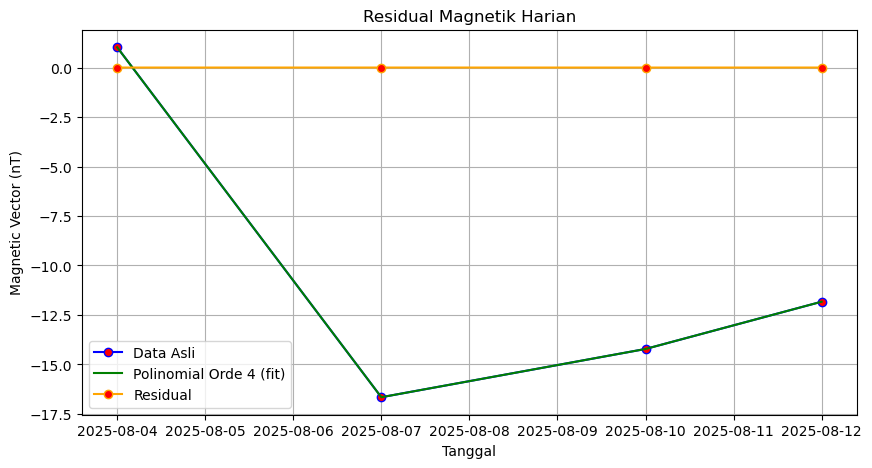

/tmp/ipykernel_1003/3050661494.py:7: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(x, y, deg=4)


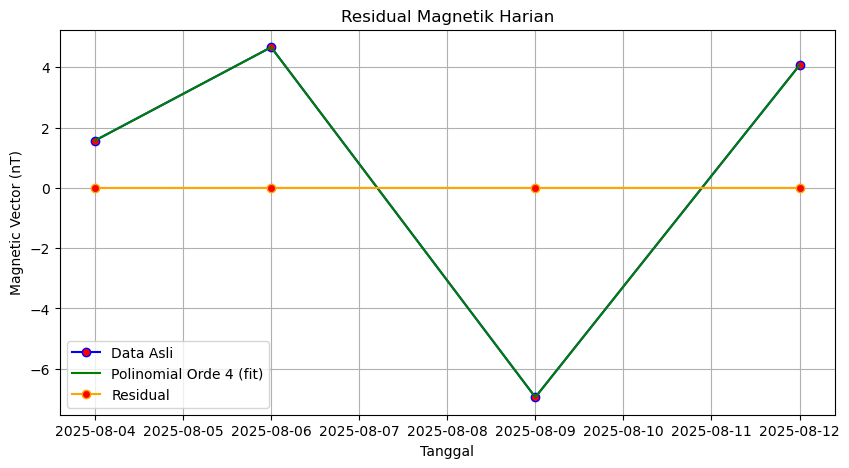

In [19]:
def remove_seasonal(ds):
    # Ambil sumbu x sebagai angka (misalnya konversi waktu ke ordinal)
    x = ds['date'].astype('datetime64[D]').astype(int)  # ubah datetime ke integer
    y = ds.values

    # Fit polinomial orde 4
    coeffs = np.polyfit(x, y, deg=4)
    poly_func = np.poly1d(coeffs)

    # Hitung nilai fit
    y_fit = poly_func(x)

    # Buat DataArray untuk fit
    da_fit = xr.DataArray(
        y_fit,
        coords={'date': ds['date']},
        dims=['date'],
        name='polyfit_4'
    )

    # Hitung residual (nilai asli - fit)
    residual = ds - da_fit
    residual.name = 'residual'

    # Plot data
    plt.figure(figsize=(10,5))
    plt.plot(ds['date'], ds, 'o-', markerfacecolor='red', color='blue', label="Data Asli")
    plt.plot(ds['date'], da_fit, color='green', label="Polinomial Orde 4 (fit)")
    plt.plot(ds['date'], residual, 'o-', markerfacecolor='red', color='orange', label="Residual")
    plt.xlabel("Tanggal")
    if 'B_NEC' in ds.name:
        plt.title("Residual Magnetik Harian")
        plt.ylabel("Magnetic Vector (nT)")
    elif 'Absolute_VTEC' in ds.name:
        plt.title("Residual Harian Total Electron Content (TEC)")
        plt.ylabel("Vertical TEC (TECU)")
    plt.legend()
    plt.grid(True)
    plt.show()

    return residual

day_residual_MAG_A, night_residual_MAG_A = remove_seasonal(day_median_MAG_A), remove_seasonal(night_median_MAG_A)
#day_residual_TEC_A, night_residual_TEC_A = remove_seasonal(day_median_TEC_A), remove_seasonal(night_median_TEC_A)

###**D. Filtering Data SWARM**

Medan magnet dan kondisi ionosfer Bumi tidak hanya dipengaruhi oleh aktivitas tektonik, melainkan juga oleh fenomena luar angkasa seperti badai geomagnetik dan radiasi matahari. Oleh karena itu, filtering data berdasarkan parameter-parameter geofisika dan ruang angkasa menjadi sangat penting untuk mendapatkan nilai kemagnetan yang tenang agar deteksi anomali benar-benar merefleksikan proses tektonik, bukan gangguan eksternal.

1. ap Index

    ap index adalah indeks geomagnetik global yang merepresentasikan tingkat gangguan medan magnet Bumi dalam satuan linier. Nilai ap berasal dari konversi indeks Kp (yang berskala logaritmik dan berbasis observasi visual di stasiun geomagnetik) ke skala linier yang lebih mudah digunakan dalam pemodelan fisik. Indeks ini dinyatakan dalam nilai numerik antara 0 hingga 400, di mana nilai rendah menunjukkan kondisi geomagnetik tenang, sementara nilai tinggi menandakan badai geomagnetik besar.

    Nilai ap dihitung setiap 3 jam dari nilai Kp. Dalam studi prekursor gempa, ap index digunakan untuk menyaring periode-periode dengan aktivitas geomagnetik tinggi agar tidak terjadi salah interpretasi terhadap anomali data medan magnet atau ionosfer.

2. Dst Index

    Dst (Disturbance storm time) index mengukur perubahan medan magnet horizontal di daerah ekuator dan dihitung dalam nilai per jam. Nilai Dst negatif menandakan pelemahan medan magnet akibat badai geomagnetik. Dst lebih kecil dari -30 nT dianggap sebagai tanda bahwa Bumi sedang mengalami badai geomagnetik ringan hingga sedang.

    Badai geomagnetik menyebabkan penurunan indeks Dst dan menciptakan arus ring current di magnetosfer yang dapat menginduksi data magnetometer Swarm. Selain itu, badai geomagnetik juga menyebabkan fluktuasi densitas elektron di ionosfer, yang secara langsung mempengaruhi data Total Electron Content (TEC). Oleh karena itu, data SWARM yang dikumpulkan saat nilai Dst terlalu rendah harus dikesampingkan untuk menghindari deteksi positif palsu (false positive) dalam studi prekursor.

3. F10.7 Index

    F10.7 cm flux index mengukur intensitas emisi matahari pada panjang gelombang 10.7 cm. Nilai ini berkorelasi erat dengan jumlah sinar ultraviolet dan X-ray yang mencapai atmosfer atas Bumi dan berdampak langsung pada kondisi ionosfer.

    Lonjakan nilai F10.7 menunjukkan peningkatan radiasi matahari yang menyebabkan peningkatan densitas elektron di ionosfer secara global, tanpa adanya keterkaitan dengan aktivitas seismik. Dalam analisis prekursor gempa menggunakan TEC dari satelit SWARM, perubahan ini dapat dengan mudah disalahartikan sebagai sinyal prekursor jika tidak difilter terlebih dahulu.

Selanjutnya, lakukan filtering data. Filtering data dilakukan berdasarkan:

* ap < 25 nT (tenang),

* |Dst| ≤ 20 nT (tidak ada badai besar),

* dan F10.7 < 120 sfu.


In [20]:
def filter_geom(da, ds):
    # Ambil tanggal
    date = ds["Timestamp"].dt.floor("D")

    # Buat kondisi per tanggal
    bad_days = ((ds["ap"] > 25) & (np.abs(ds["Dst"]) >= 20) & (ds["F107"] > 120)).groupby(date).any()

    # Broadcast ke resolusi asli
    bad_days_full = xr.DataArray(
        bad_days.sel(floor=da["date"]).values,
        coords={"date": da["date"]},
        dims=["date"]
    )

    # Masking da
    da_filtered = da.where(~bad_days_full)

    return da_filtered

day_filter_MAG_A, night_filter_MAG_A = filter_geom(day_residual_MAG_A, ds_day_MAG_A), filter_geom(night_residual_MAG_A, ds_night_MAG_A)
#day_filter_TEC_A, night_filter_TEC_A = filter_geom(day_residual_TEC_A, ds_day_TEC_A), filter_geom(night_residual_TEC_A, ds_night_TEC_A)

Terakhir, kita plot nilai median hariannya. Dari nilai median harian ini, kita hitung nilai median dari keseluruhan data median harian dan nilai inter quartile range (IQR) nya yang dapat kita gunakan sebagai batas threshold. Nilai median dan IQR yang dihitung adalah nilai yang berasal dari hari tenang yang telah difilter sebelumnya. Selanjutnya, jika nilai median harian melebihi threshold dan tidak terdapat gangguan geomagnetik di hari tersebut, maka dianggap sebagai anomali yang berkaitan dengan aktivitas seismik. 

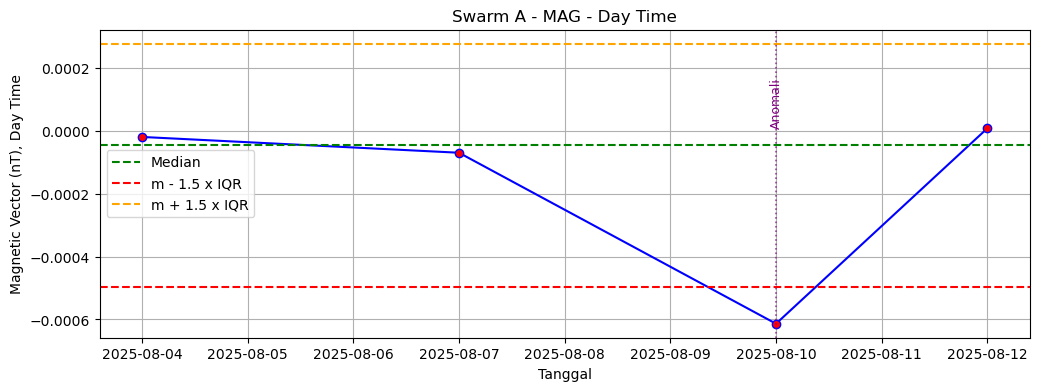

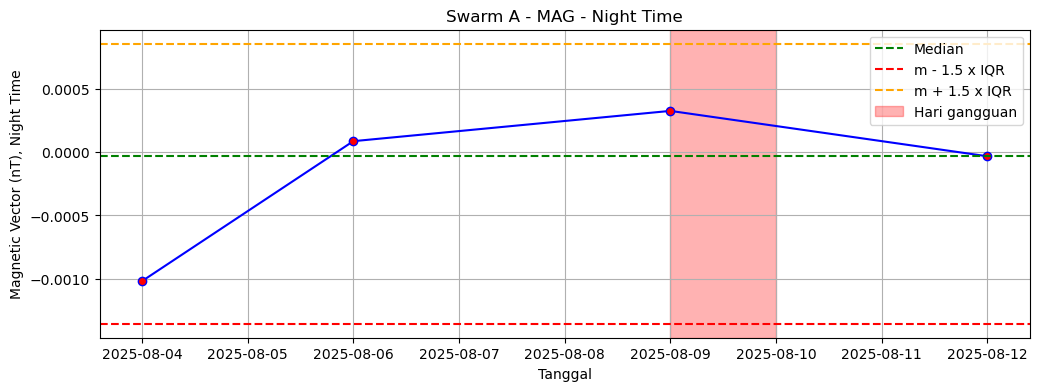

In [21]:
def median_func(ds):
    # Hitung Q1 dan Q3
    q1 = ds.quantile(0.25, dim="date")
    q3 = ds.quantile(0.75, dim="date")

    # Hitung IQR
    iqr = q3 - q1

    # Hitung median
    median = ds.median().item()

    # Hitung batas bawah dan atas
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr

    return median, lower.item(), upper.item()

def plot_final(ds_residual, ds_filter, ds, title, code, day_night):
    # Tentukan tanggal-tanggal dengan hari gangguan
    date_idx = ds['Timestamp'].dt.floor('D')
    cond = (ds['ap'] > 25) & (np.abs(ds['Dst']) >= 20) & (ds['F107'] > 120)
    bad_days = cond.groupby(date_idx).any()
    bad_dates = bad_days.where(bad_days, drop=True)['floor'].values 

    # Hitung median, lower, upper
    median, lower, upper = median_func(ds_filter)

    # Plot data dengan batas bawah dan atas
    plt.figure(figsize=(12,4))
    plt.plot(ds_residual['date'], ds_residual, 'o-', markerfacecolor='red', color='blue')
    plt.axhline(median, color='green', linestyle='--', label="Median")
    plt.axhline(lower, color='red', linestyle='--', label="m - 1.5 x IQR")
    plt.axhline(upper, color='orange', linestyle='--', label="m + 1.5 x IQR")

    # Tambahkan area gangguan berupa shading warna merah
    for d in bad_dates:
        start = pd.Timestamp(d)                  # awal hari
        end   = start + pd.Timedelta(days=1)     # awal hari berikutnya
        plt.axvspan(start, end, color='red', alpha=0.3, zorder=0, label="Hari gangguan")

    # Cari anomali: nilai di luar batas
    anomalies = (ds_residual < lower) | (ds_residual > upper)
    anom_dates = ds_residual['date'].where(anomalies, drop=True)

    # Tambahkan garis vertikal + teks "Anomali"
    ymax = float(ds_residual.max()) * 1.15  # posisi teks sedikit di atas data max
    for d in anom_dates.values:
        plt.axvline(d, color='purple', linestyle=':', linewidth=1.2, alpha=0.7)
        plt.text(d, ymax, "Anomali", color='purple', fontsize=9,
                rotation=90, ha='center', va='bottom')

    plt.xlabel("Tanggal")
    if code == 'MAG':
        plt.title(title + " - " + day_night + " Time")
        plt.ylabel("Magnetic Vector (nT), " + day_night + " Time")
    elif code == 'TEC':
        plt.title(title + " - " + day_night + " Time")
        plt.ylabel("Vertical TEC (TECU), " + day_night + " Time")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_final(day_residual_MAG_A, day_filter_MAG_A, ds_day_MAG_A, "Swarm A - MAG", "MAG", "Day")
plot_final(night_residual_MAG_A, night_filter_MAG_A, ds_night_MAG_A, "Swarm A - MAG", "MAG", "Night")
#plot_final(day_residual_TEC_A, day_filter_TEC_A, ds_day_TEC_A, "Swarm A - TEC", "TEC", "Day")
#plot_final(night_residual_TEC_A, night_filter_TEC_A, ds_night_TEC_A, "Swarm A - TEC", "TEC", "Night")